# Specific Test IV. Exploring Equivariant Neural Networks

**Task:** Use an Equivariant Neural Network of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.

**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

## Strategy

For the purpose of this test. A simple feed-forward Equivariant Neural Network was used. The network is invariant under rotations by 90 degree steps and refletion across Y-axis. The network is trained to classify the images into two classes: with and without substructure. The network is trained for 15 epochs with a batch size of 32. The network is trained using the Adam optimizer with a learning rate of 0.001 and a weight decay of 0.0001. Also StepLR scheduler is used to reduce the learning rate by a factor of 0.1 every 3 epochs.

The dataset is split in a 9:1 train-test ratio. The training set is augmented using ColorJitter and RandomRotation(180). The test set is not augmented.

Since the below model performs well, more complicated models were not explored.

## Results

**ROC-AUC Score:** 0.999952

**Training Curve:**

<img src="../results/test-4-training-plot.png" alt="Training Plot"/>

**ROC Curve:**

<img src="../results/test-4-roc-plot.png" alt="ROC plot"/>

## Importing Library

In [25]:
!pip install e2cnn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [26]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from e2cnn import gspaces
from e2cnn import gspaces, nn as e2nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading Data

In [27]:
base_dir = '../dataset/test4/lenses'

train_df = pd.DataFrame(columns = ['path', 'label'])

label_map = {'no_sub':0, 'sub':1}
val_label_map = {0:'no_sub', 1:'sub'}

for i in label_map.keys():
    entries = [os.path.join(base_dir, i, j) for j in os.listdir(os.path.join(base_dir, i))]
    temp_df = pd.DataFrame({'path':entries, 'label':i})
    train_df = pd.concat([train_df, temp_df], ignore_index=True)

train_df.head()

,path,label
0,../dataset/test4/lenses/no_sub/image_174787512...,no_sub
1,../dataset/test4/lenses/no_sub/image_585018401...,no_sub
2,../dataset/test4/lenses/no_sub/image_206425288...,no_sub
3,../dataset/test4/lenses/no_sub/image_224386755...,no_sub
4,../dataset/test4/lenses/no_sub/image_270482039...,no_sub


In [28]:
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Train split:\n{train_df['label'].value_counts()}\n")
print(f"Test split:\n{test_df['label'].value_counts()}")

Train split:
sub       4500
no_sub    4500
Name: label, dtype: int64

Test split:
sub       500
no_sub    500
Name: label, dtype: int64


In [29]:
class Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx]['label']
        label = label_map[label]
        
        return img, label

In [30]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomRotation(180),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = Dataset(train_df, transform=train_transforms)
test_dataset = Dataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

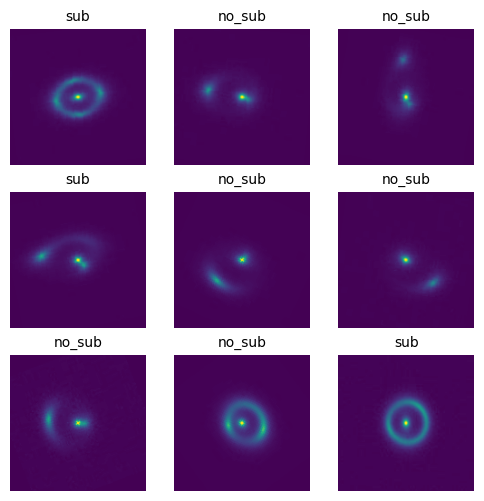

In [31]:
def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = images[i*4 + j]
            label = labels[i*4 + j].item()
            ax[i][j].imshow(image.permute(1, 2, 0))
            title = [k for k, v in class_map.items() if v == label][0]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, label_map)

## Defining Model

In [32]:
class D4SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=2):
        
        super(D4SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 90 degrees(2*pi/4) 
        # and reflection about Y-axis, modelled by C8
        self.r2_act = gspaces.FlipRot2dOnR2(N=4)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = e2nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # Unlike CNNs, we choose the output type of the convolutional layer to be a feature feilds
        # that are equivariant under the group C8 instead of normal feature maps.
        out_type = e2nn.FieldType(self.r2_act, 12*[self.r2_act.regular_repr])
        
        # convolution 1
        # the first covolution layer outputs 12 regular feature fields of C8 as denoted by the out_type
        self.block1 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, stride=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type   
        
        # convolution 2
        # the second covolution layer outputs 24 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block2 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, stride=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )

        # pointwise average pooling is used instead of max pooling or average pooling
        # to preserve the rotational symmetry of the feature fields
        self.pool1 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        in_type = self.block2.out_type

        # convolution 3
        # the third covolution layer outputs 24 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block3 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        in_type = self.block3.out_type

        # convolution 4
        # the fourth covolution layer outputs 48 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block4 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        # group pooling provides a way to aggregate information from all the feature fields,
        # while preserving the rotational symmetry of the feature fields
        self.gpool = e2nn.GroupPooling(out_type)
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(4800, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):

        x = e2nn.GeometricTensor(input, self.input_type)
        x = self.block1(x)
        x = self.block2(x)

        x = self.pool1(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.gpool(x)

        x = x.tensor
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

## Hyper-parameters and Training

In [33]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_val_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), '../notebooks/test-4.ipynb') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Train Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc, best_acc

In [34]:
model = D4SteerableCNN(n_classes=2).to(device)

epochs = 15
lr = 0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [35]:
train_losses, train_acc, test_losses, test_acc, best_acc = train(model, epochs, optimizer, loss_function, scheduler, device, train_loader, test_loader)

Epoch: 1


Test	: 100%|██████████| 32/32 [00:01<00:00, 29.09it/s]


Train Loss: 0.307, Train Acc: 0.847, Test Loss: 0.106, Train Acc: 0.963

Epoch: 2


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.10it/s]


Train Loss: 0.099, Train Acc: 0.962, Test Loss: 0.087, Train Acc: 0.959

Epoch: 3


Test	: 100%|██████████| 32/32 [00:01<00:00, 27.93it/s]


Train Loss: 0.073, Train Acc: 0.970, Test Loss: 0.036, Train Acc: 0.989

Epoch: 4


Test	: 100%|██████████| 32/32 [00:01<00:00, 27.87it/s]


Train Loss: 0.023, Train Acc: 0.992, Test Loss: 0.020, Train Acc: 0.995

Epoch: 5


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.23it/s]


Train Loss: 0.020, Train Acc: 0.992, Test Loss: 0.011, Train Acc: 0.998

Epoch: 6


Test	: 100%|██████████| 32/32 [00:01<00:00, 25.95it/s]


Train Loss: 0.015, Train Acc: 0.995, Test Loss: 0.013, Train Acc: 0.995

Epoch: 7


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.24it/s]


Train Loss: 0.012, Train Acc: 0.996, Test Loss: 0.014, Train Acc: 0.997

Epoch: 8


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.46it/s]


Train Loss: 0.012, Train Acc: 0.996, Test Loss: 0.010, Train Acc: 0.999

Epoch: 9


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.46it/s]


Train Loss: 0.012, Train Acc: 0.996, Test Loss: 0.012, Train Acc: 0.996

Epoch: 10


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.43it/s]


Train Loss: 0.012, Train Acc: 0.996, Test Loss: 0.012, Train Acc: 0.994

Epoch: 11


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.64it/s]


Train Loss: 0.012, Train Acc: 0.996, Test Loss: 0.019, Train Acc: 0.998

Epoch: 12


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.38it/s]


Train Loss: 0.013, Train Acc: 0.995, Test Loss: 0.017, Train Acc: 0.993

Epoch: 13


Test	: 100%|██████████| 32/32 [00:01<00:00, 28.47it/s]


Train Loss: 0.010, Train Acc: 0.998, Test Loss: 0.012, Train Acc: 0.995

Epoch: 14


Test	: 100%|██████████| 32/32 [00:01<00:00, 27.43it/s]


Train Loss: 0.012, Train Acc: 0.996, Test Loss: 0.009, Train Acc: 0.999

Epoch: 15


Test	: 100%|██████████| 32/32 [00:01<00:00, 27.79it/s]


Train Loss: 0.012, Train Acc: 0.996, Test Loss: 0.009, Train Acc: 0.998



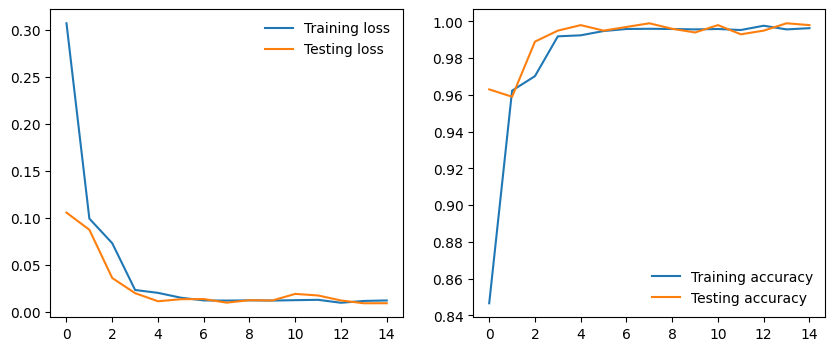

In [36]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Testing accuracy')
plt.legend(frameon=False)

## Testing

The best model is loaded for testing and the results are plotted.

In [38]:
model = D4SteerableCNN(n_classes=2).to(device)
model.load_state_dict(torch.load('../notebooks/test-4.ipynb'))

<All keys matched successfully>

In [39]:
y_true = []
y_pred_class = []
y_pred_prob = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred_class.extend(preds.cpu().numpy())
        y_pred_prob.extend(output.cpu().numpy())

100%|██████████| 32/32 [00:01<00:00, 27.76it/s]


In [40]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

print(classification_report(y_true, y_pred_class, target_names=label_map.keys()))

              precision    recall  f1-score   support

      no_sub       1.00      1.00      1.00       500
         sub       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



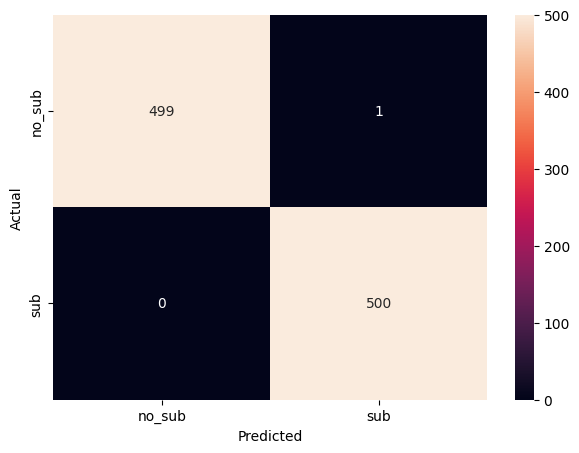

In [41]:
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [42]:
print(f"ROC-AUC Score: {roc_auc_score(y_true, np.array(y_pred_prob)[:,1], multi_class='ovr')}")

ROC-AUC Score: 0.999952


no_sub   ROC-AUC: 0.999968
sub      ROC-AUC: 0.999952


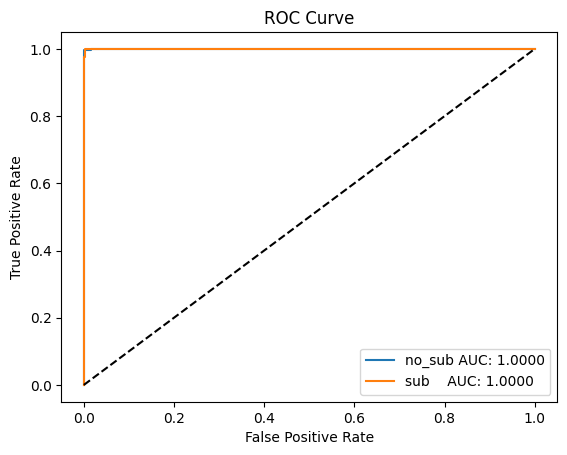

In [43]:
y_true_dummies = pd.get_dummies(y_true).values

auc_scores = {}
for i in range(2):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_true_dummies[:, i], np.array(y_pred_prob)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    print(f"{(val_label_map[i]).ljust(8)} ROC-AUC: {auc_score}")
    auc_scores[val_label_map[i]] = auc_score
    plt.plot(fpr_i, tpr_i, label=f"{(val_label_map[i]).ljust(6)} AUC: {auc_score:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()